# Visualizing Simulated Calorimeter Hits

The following notebook contains examples of 1, 2, and 3-dimensional hisograms plotted using RDataFrame within the pyroot framework.

As always, we begin with imports...

In [1]:
import ROOT
from ROOT import Math
from pprint import pprint   # For formatted printing.

Welcome to JupyROOT 6.24/06


---
## Reading Data

Using magic commands, we can execute bash commands. Here we find the available trees in the ROOT data file using a BASH command. The `-l` flag tells ROOT to output additional information. We want to identify a TTree.

In [2]:
%%bash
rootls -l /work/rhillman/Data/photonGun_1000_reco_990.root

TTree  May 25 17:41 2023 events          "events data tree"
TTree  May 25 17:41 2023 events          "events data tree"
TTree  May 25 17:41 2023 podio_metadata  "metadata tree for podio I/O functionality"


In this file, there is a TTree available called "events," which we will import into a dataframe for ready manipulation and plotting. There are two of them, but they are different versions of the same thing.

In [3]:
treename = "events"
filename = "/work/rhillman/Data/photonGun_1000_reco_990.root"
df = ROOT.RDataFrame(treename, filename)

We have now established the RDataFrame object, and can use corresponding methods for reading, filtering, and plotting. 

Probably the best method for reading branches here will be to call the `Print()` method on the tree called "events", as shown below. We can pass options "all", "toponly", or "clusters", or we can use wildcarding to search for relevant branches, as shown below. 

See the `Print()` documenation including available arguments, [here](https://root.cern/doc/v628/classTTree.html#a3d27bde3ec51f3985ea6e0bbfe15863c).

In [4]:
%%cpp
events->Print("ECal*")

******************************************************************************
*Chain   :events    : /work/rhillman/Data/photonGun_1000_reco_990.root       *
******************************************************************************
******************************************************************************
*Tree    :events    : events data tree                                       *
*Entries :       10 : Total =       138512552 bytes  File  Size =   62843895 *
*        :          : Tree compression factor =   2.20                       *
******************************************************************************
*Br    0 :ECalEndcapCollection : Int_t ECalEndcapCollection_                 *
*Entries :       10 : Total  Size=       6193 bytes  File Size  =        258 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.06     *
*............................................................................*
*Br    1 :ECalEndcapCollection.cellID : ULong_t cell

Warning in <TClass::Init>: no dictionary for class edm4hep::TrackerHitPlaneData is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Vector2f is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Quantity is available
Warning in <TClass::Init>: no dictionary for class podio::version::Version is available


Alternatively, we can call the `GetColumnNames()` method in Python to figure out the available column names. A drawback of this method is that it does not print the additional information that is included by the `Print()` method, and the output is arguably not as readable. However, it is probably better to use for scripts.

The `Scan()` method allows us to display the contents of branches in a table. It can also be useful.

For a more comprehensive description of how to use it, see the [documentation](https://root.cern/doc/v628/classTTree.html#af8a886acab51b16d8ddbf65667c035e4).

In [5]:
# pprint(f"{df.GetColumnNames()}")

In [6]:
# %%cpp
# events->Scan("ECalBarrelCollection.position.y")

Using info from these searches, we will assign new aliases for our branches.

In [7]:
# Barrel Collections
df = df.Alias("barrel_x", "ECALBarrel.position.x")\
    .Alias("barrel_y", "ECALBarrel.position.y")\
    .Alias("barrel_z", "ECALBarrel.position.z")\
    .Alias("barrel_t", "ECALBarrel.time")

# Endcap Collections
df = df.Alias("endcap_x", "ECALEndcap.position.x")\
    .Alias("endcap_y", "ECALEndcap.position.y")\
    .Alias("endcap_z", "ECALEndcap.position.z")\
    .Alias("endcap_t", "ECALEndcap.time")


In [8]:
# %%cpp

# auto df = df.Define("r", radius, {"barrel_x", "barrel_y"})

---
## Manipulating the Dataframe

Here, let's define a new column to represent the radius, using [df.Define().](https://root.cern/doc/v628/classROOT_1_1RDF_1_1RInterface.html#a4698601205a55ac49279150d56fc904f)

In [9]:
df = df.Define("r", "ROOT::Math::XYZTVector('x', 'y', 'z', 't').mag()")

---
## Visualization

### Aesthetics

To add some flair to the plot, we can define some custom colors. Here are some available colors...

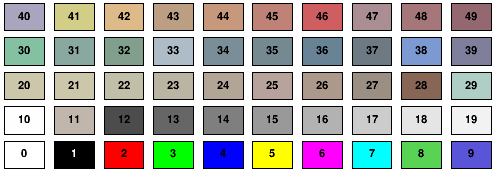

In [10]:
c = ROOT.TCanvas("c", "Fill Area Colors", 0, 0, 500, 200)
c.DrawColorTable()
c.Draw()

We want to define new TColors. If we want to know more about how a given object or method works, we can do the following:

In [11]:
# How does this object work?
?ROOT.TColor

Docstring:      cppyy object proxy (internal)
Init docstring:
TColor::TColor()
TColor::TColor(int color, float r, float g, float b, const char* name = "", float a = 1)
TColor::TColor(float r, float g, float b, float a = 1)
TColor::TColor(const TColor& color)
Type:           TColor_meta
Subclasses:     


We will proceed by defining our own colors and assigning them to a new color index.

In [12]:
# GetFreeColorIndex() finds an available color index for our color.
icc = index_canvas_color = ROOT.TColor.GetFreeColorIndex()
canvascolor = ROOT.TColor(
    icc,
    1, 1, 1,
    a=1,
    name="canvascolor"
)

### Plotting 1-D Histograms

Now, we can create a canvas and fill it with histograms.

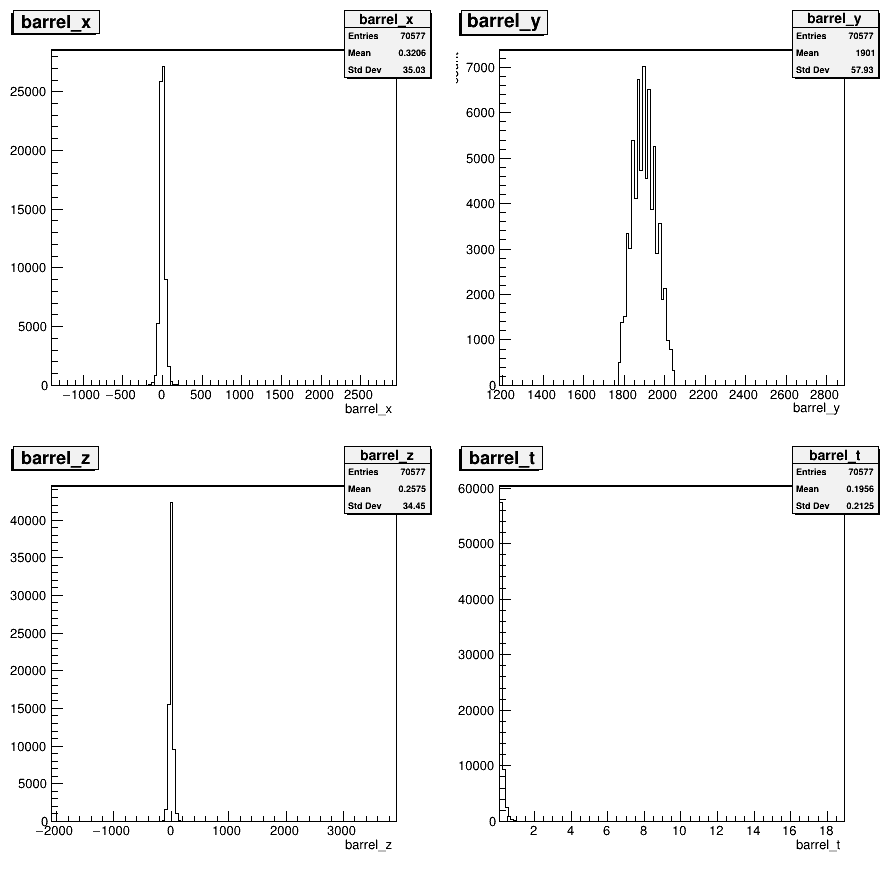

In [13]:
# %jsroot on

c = ROOT.TCanvas("c1", "1-D Histograms", 900, 900)
c.Divide(2, 2)

h1 = df.Histo1D("barrel_x")
h2 = df.Histo1D("barrel_y")
h3 = df.Histo1D("barrel_z")
h4 = df.Histo1D("barrel_t")

c.cd(1)
h1.Draw()
c.cd(2)
h2.Draw()
c.cd(3)
h3.Draw()
c.cd(4)
h4.Draw()

c.Draw()


### 2-D Plots

Now, we will visualize the plots differently. We'll use the Histo2D class to plot the data as cross-sections. First, we'll customize the plots.

In [14]:
ROOT.gStyle.SetOptTitle(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetTitleColor(0)

# Set axis, label, and title attributes
ROOT.gStyle.SetAxisColor(0, "XYZ")
ROOT.gStyle.SetLabelColor(0, "XYZ")
ROOT.gStyle.SetLabelSize(0.02, "XYZ")

ROOT.gStyle.SetOptLogz()        # Useful for forcing more visible texture out of high-energy events/getting a better feel for background.

Now, we'll handle the plotting.

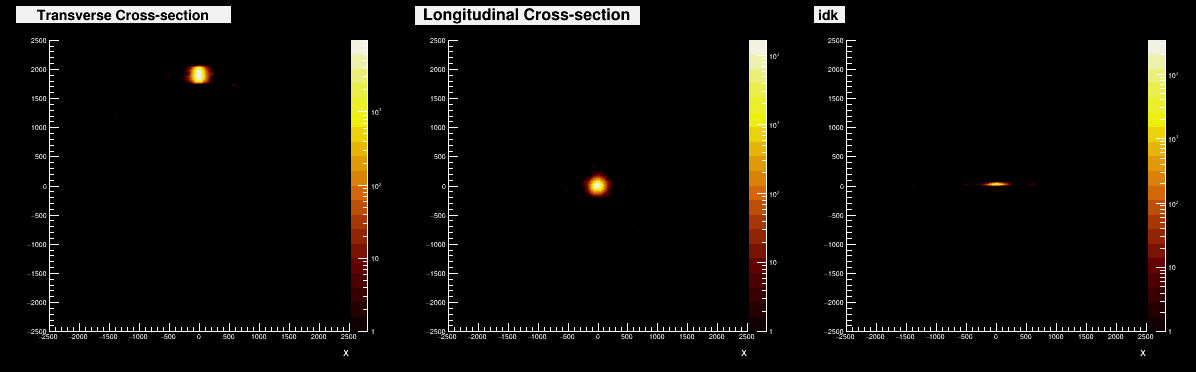

In [15]:
c = ROOT.TCanvas("c2", "2-D Histograms", 1200, 400)
c.Divide(3, 1)
c.SetFillColorAlpha(1, 1)
c.SetBorderMode(0)
c.SetBorderSize(2)

# Set the color palette
ROOT.gStyle.SetPalette(53)

# Define the number of bins and the ranges for the x and y axes
xbins = ybins = tbins = 100
xmax = ymax = tmax = 2500
xmin = ymin = tmin = -xmax


c.cd(1)
c.GetPad(1).SetFillColor(1)
h1 = df.Histo2D(("h1", "Transverse Cross-section;x;y",
                 xbins, xmin, xmax,
                 ybins, ymin, ymax),
                "barrel_x", "barrel_y")
h1.Draw("CONT4 Z")

c.cd(2)
c.GetPad(2).SetFillColor(1)
h2 = df.Histo2D(("h2", "Longitudinal Cross-section;x;z",
                 xbins, xmin, xmax, 
                 ybins, ymin, ymax), 
                "barrel_x", "barrel_z")
h2.Draw("CONT4 Z")

c.cd(3)
c.GetPad(3).SetFillColor(1)
h3 = df.Histo2D(("h3", "idk;x;t",
                 xbins, xmin, xmax,
                 tbins, tmin, tmax),
                "barrel_x", "ECALBarrel.time")
h3.Draw("CONT4 Z")

c.Draw()


### 3-D Plotting

???

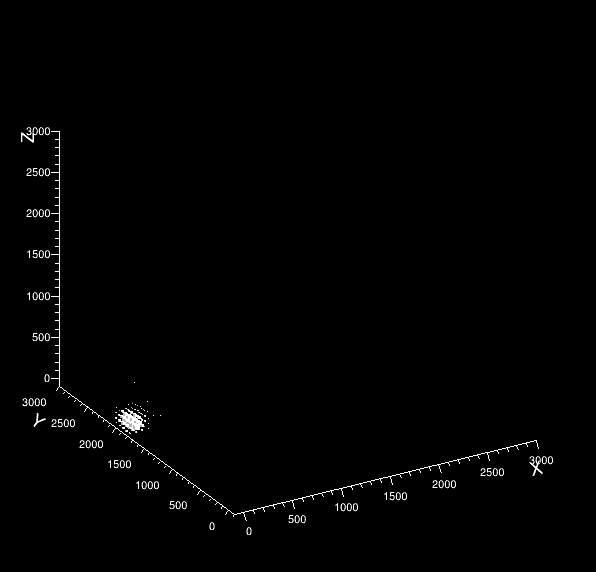

In [16]:
ROOT.gStyle.SetOptLogz(0)

c = ROOT.TCanvas("c3", "3-D Histogram", 600, 600)
c.SetFillColor(1)
c.Draw()
c.cd(1)

# Set axis, label, and title attributes
ROOT.gStyle.SetAxisColor(0, "XYZ")
ROOT.gStyle.SetLabelColor(0, "XYZ")
ROOT.gStyle.SetLabelSize(0.02, "XYZ")
ROOT.gStyle.SetTitleColor(0, "XYZ")

xbins = ybins = zbins = 50
xmin = ymin = zmin = -100
xmax = ymax = zmax = 3000

h = df.Histo3D(("3D Cross-section", ";X;Y;Z", xbins, xmin, xmax,
                ybins, ymin, ymax, zbins, ymin, ymax), "barrel_x", "barrel_y", "barrel_z")

h.Draw("BOX3")

c.Draw()
